# City Pooling Notebook 
## Introduction
### Problem statement

This problem has been submitted by one of my colleagues. Besides being both a nice guy and a talented developper, he also is the president of the roller federation. He therefore has to sometimes participate in the construction of french roller hockey tournaments.

That is where he sometimes is faced with quite a challenge: dividing dozens of teams from various cities into smaller groups, which will then compete in round-robin tournaments. The problem is that he must try to be as efficient as possible when it comes to the cost of travel for each team. The cost of a scenario may be something as simple as the sum of total distance traveled by the teams, but it can also get far more complicated when trying to add some fairness to it: 
- trying to minimze the distance run by the team with the greatest one
- adding other criteria to the cost function: adding the standard deviation of total distance for each team to the overall cost
- putting some weight over the "richest" teams by considering the cost of distance being smaller for them...

The simplest case would be minimizing total distance run by all teams, and after analysis: given points on a plane, how do I split them in same size groups so that total distance between points in the same group is minimized? 



![title](img/16_cities.png)
<i><center>Example of 16 cities to split into 4 pools of 4</center></i>


### Why does this problem seem interesting to me?
Besides the immediate reward of being helpful to a colleague, the more I gave thought to this problem, the more I noticed that it presents many nice aspects:
- being kind of "trading salesman"-ish, it looks like it would be an endless playground for optimization
- furthermore, many python functionalities and libraries might get involved: iterators and generators, decorators, graphical tools from matplotlib and seaborn, file writing and reading to get some persistence, calls to Google Maps API to work on real life data... 
- last but not least, when I first got to see some solutions on problem small enough to be *brutally* solved, I noticed that I could have had them simplified (sometimes solved!) just by looking at it. I might in the end get some Machine Learning algorithms working on this subject.

### Disclaimer
I am definitely not a professional developper (yet?), and my sometimes cumbersome logic or alien syntax might make seasoned readers cringe. I definitely am open to any suggestion as to improve the following.

### Imports
The below imports are used in this notebook (yet this would require some cleansing as some of them are not required here anymore).

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from itertools import combinations
from itertools import cycle
from copy import deepcopy
from collections import defaultdict
from math import factorial
import sys
import os

sys.path.append(os.path.abspath('../../src/'))
import geography.geography as geo
import solver.scorer as scorer
import importlib

As I update as I go the packages where the classes are defined, the lines below enable to reload my packages without having to restart the whole kernel.

In [2]:
# cell to reload modules
def reload_all():
    importlib.reload(geo)
    importlib.reload(scorer)   

## Geography

### What for?
First of all, I will define a class that will hold the distance cost between cities. For the first run of optimization, I will work with cost between two cities being the distance between them. That will enable me to visually check whether my code is possibly giving acurate results or being completely dumb.

I want that class to allow me to 
- create a map of cities from coordinates, or randomly set one up
- assign them names
- compute the distance matrix between every couple of cities
- show a visual representation of the map
- apply and give a visual representation of a configuration
- compute the cost of a configuration

This class will then be extended as to get real data, for example from the Google Maps APIs.

### Class definition

Class definition is all set up in the `geography.geography` module.

### Examples
#### Constructor and `show` method
##### Random constructor 
Constructor without parameters will just create a random map of n cities with default names, and compute the distance matrix with the "natural" euclidean distance.
Explaination of the distance matrix is provided in the second example.

(<matplotlib.axes._subplots.AxesSubplot at 0x2a5c227afc8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a5c2605248>)

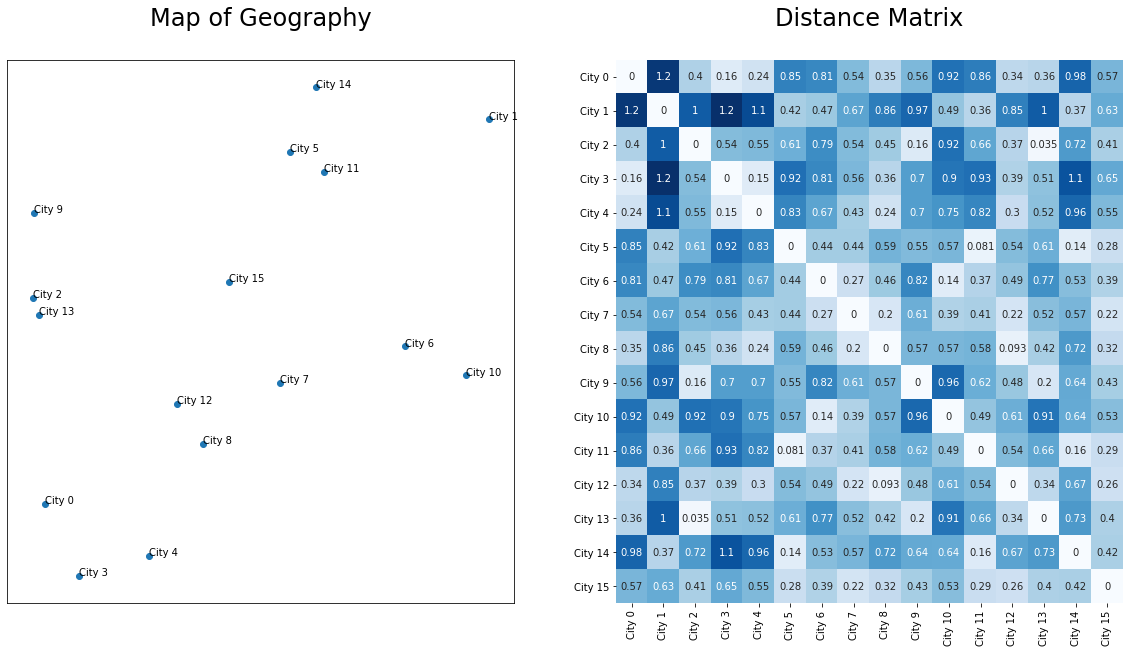

In [4]:
geog = geo.Geography(16)
geog.show(show_names=True, dist_matrix_kwargs={'annot':True})

##### Forced coordinates constructor
It is also possible to force cities coordinates with a numpy array of shape (2, n) or the names of the cities with
an iterable of names.
Here, I will create a meshgrid of 16 cities, with a unit space of 1 between cities.

(<matplotlib.axes._subplots.AxesSubplot at 0x2a5c2d86cc8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a5c2d62d48>)

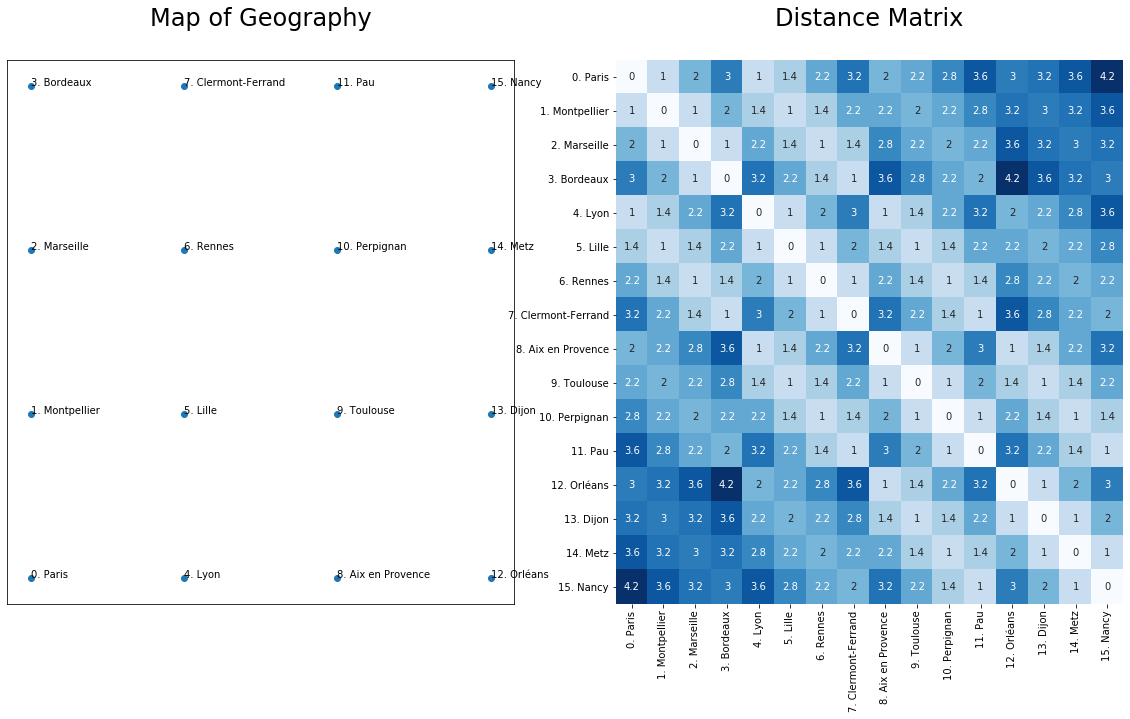

In [5]:
x, y = np.mgrid[0:4,0:4]
pos = np.vstack( [x.ravel(), y.ravel()] )

names = [
    "0. Paris",
    "1. Montpellier",
    "2. Marseille",
    "3. Bordeaux",
    "4. Lyon",
    "5. Lille",
    "6. Rennes",
    "7. Clermont-Ferrand",
    "8. Aix en Provence",
    "9. Toulouse",
    "10. Perpignan",
    "11. Pau",
    "12. Orléans",
    "13. Dijon",
    "14. Metz",
    "15. Nancy"
]

geog = geo.Geography(16, cities_coordinates=pos, cities_names=names)
geog.show(show_names=True, dist_matrix_kwargs={'annot':True})

In this example, you can see that distance from `0. Paris` to `1. Montpellier` is 1. As Euclidean distance is symetrical (dist(a,b) = dist(b,a)), so is the distance matrix.

I could have limited the distance matrix to its superior half, but I might encounter cases where going form a to b is longer (or more costly) than getting from b to a.

#### `show_config` method
The `show_config` method enables to apply a configuration to a geography, and display it.

A configuration is a dict :

   - with integer keys
   - with iterables of city indexes as values

As per the problem definition, a city index should only appear in a single pool, and only once in that pool, yet no restriction has been set in the source code.

##### `show_config` with pools as set
A way to modelize a pool would be a python set, as it enforces the fact that inside a pool, a city may only appear once. Yet it has a serious drawback.

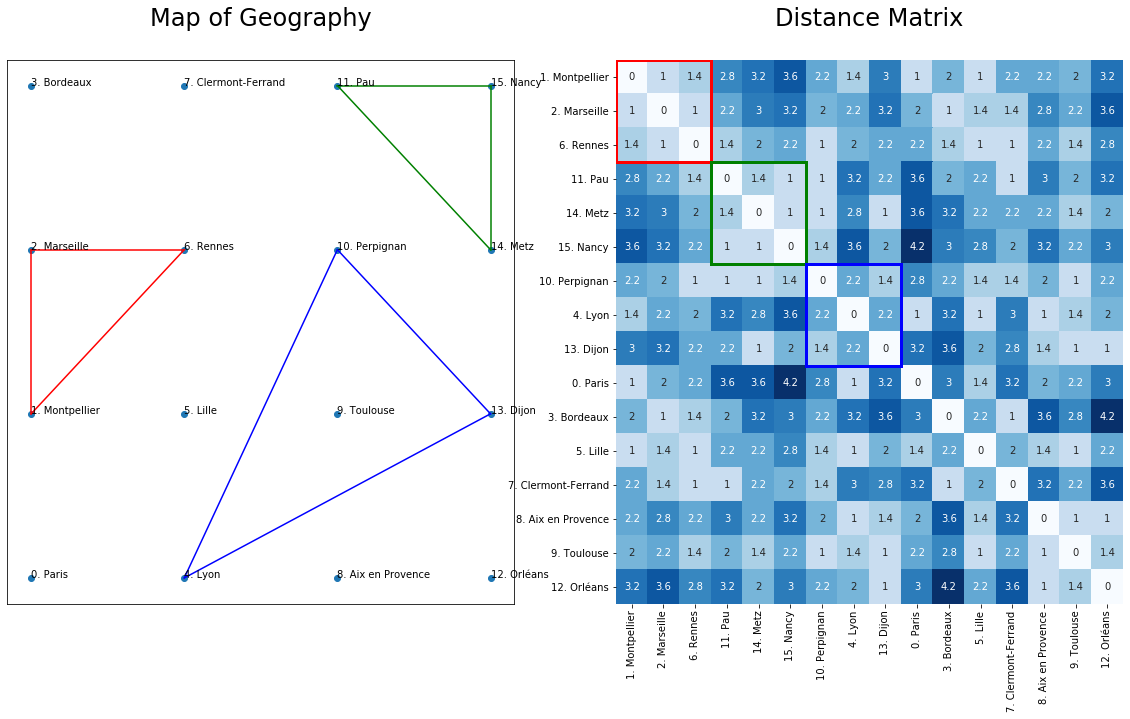

In [6]:
geog.show_config({0 : set([2,6,1]), 1: set([11,14,15]), 2: set([4,13,10])}, show_names=True, 
                 dist_matrix_kwargs={'annot':True})

The first cities in the first set were `0 : set([2,6,1])` and therefore first pool in the reordered distance matrix should have been `2: Marseille, 6: Rennes, 1: Montpellier`.

Note that python sets are unordered, this is why in the distance matrix in the above example inside a pool no order is applied and results in `1: Montpellier, 2: Marseille, 6: Rennes`

##### `show_config` with pools as lists
If I want to maintain an order inside each pool - which I will want to do later on - I need to use lists (see just below).

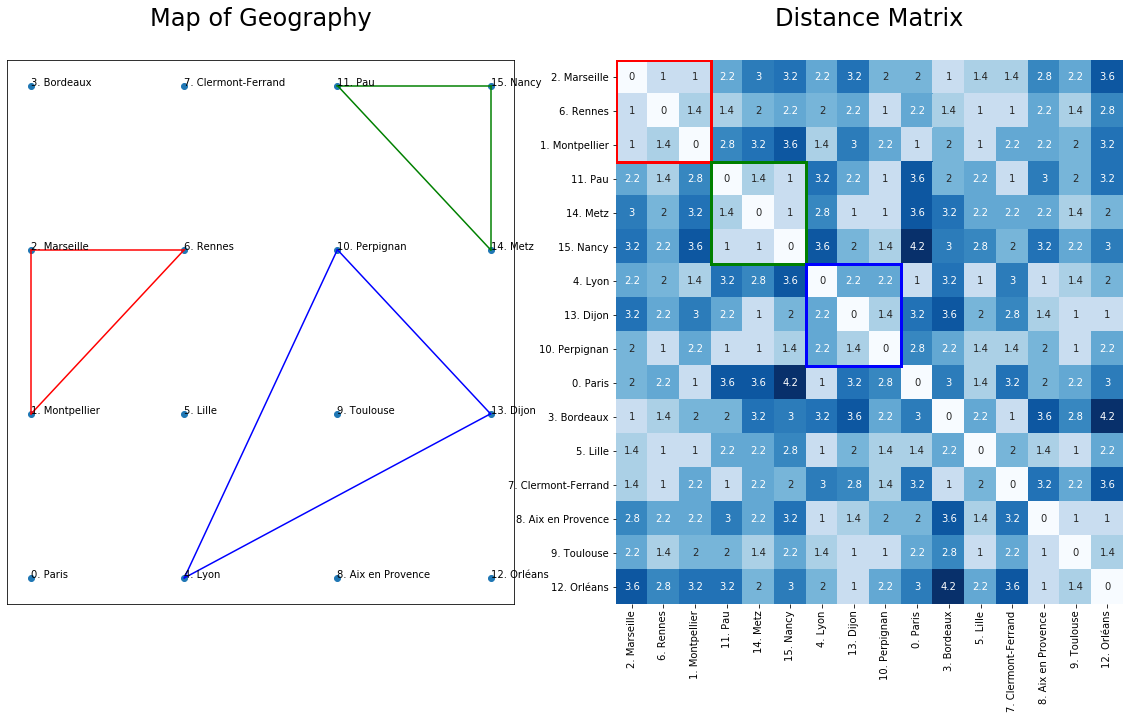

In [7]:
geog.show_config({0 : [2,6,1], 1: [11,14,15], 2: [4,13,10]}, show_names=True, 
                 dist_matrix_kwargs={'annot':True})

Here, the order inside each pool has been kept.

##### Why choosing configuration to be a dict rather than another iterable?
It might seem weird to choose to use a dict rather than a list for a configuration. But in future works, if I try to work on pools which are not the same size, I will need to build an enumeration system (and therefore need to be able to get to a pool with an integer index).

### Random and optimal solution to the meshgrid problem

Let's now try to compare the (trivial) solution of this problem (a 4x4 grid is not much of a challenge!) and a random one. For this example, I will try to minimize the total distance traveled by all teams.

First, I need to create a random configuration.

In [8]:
rand_perm = np.array(range(16))
print(rand_perm)
np.random.shuffle(rand_perm)
print(rand_perm)
rand_configuration = {i: list(rand_perm[4*i:4*(i+1)]) for i in range(4)}
print(rand_configuration)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[14  9  0  2  1  8 12  7 13 11  4  3  6 15  5 10]
{0: [14, 9, 0, 2], 1: [1, 8, 12, 7], 2: [13, 11, 4, 3], 3: [6, 15, 5, 10]}


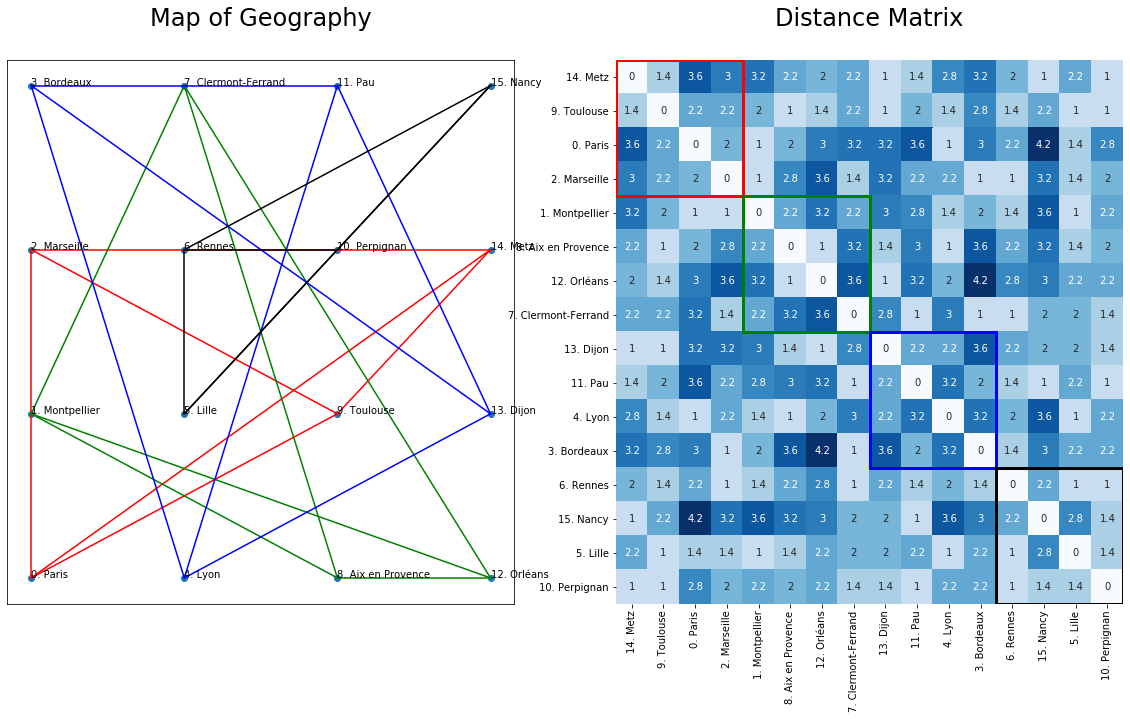

In [9]:
geog.show_config(rand_configuration, show_names=True, 
                 dist_matrix_kwargs={'annot':True})

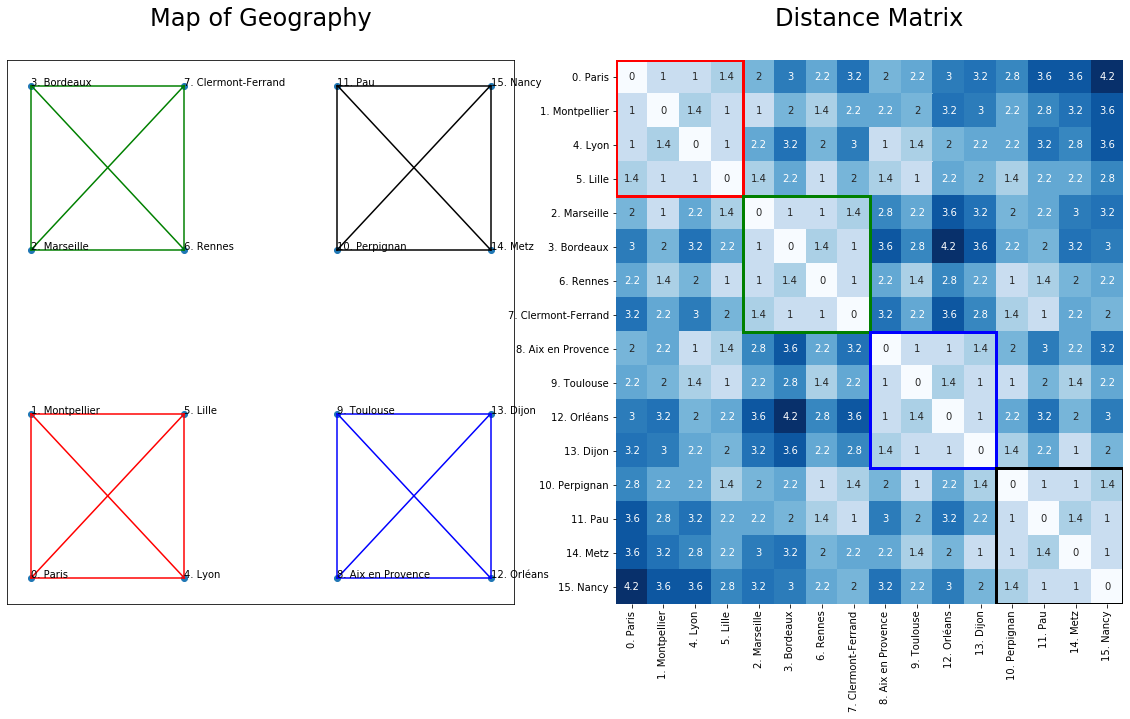

In [10]:
geog.show_config({0 : [0,1,4,5], 1: [2,3,6,7], 2: [8,9,12,13], 3: [10,11,14,15]}, show_names=True, 
                 dist_matrix_kwargs={'annot':True})

One nice thing to notice is that finding a solution to the problem consists in permuting the cities in pools so that the lightest cells in the distance matrix get closest to the diagonal.

## Solver
### What for?
Obviously, to solve the problem! That means: find the configuration that minimize my criterion cost.

The solver package will have some submodules:

- a `scorer` module, that will provide a class enabling to compute the cost of a configuration applied to a geography
- a `scoring_funcs` module, which will be a library of various scoring functions
- a `solver` module, that will provide various algorithms to find a globally or locally optimal solution to the problem


In [11]:
myScorer = scorer.Scorer(geog)
print(myScorer.score({0 : [0,1,4,5], 1: [2,3,6,7], 2: [8,9,12,13], 3: [10,11,14,15]}))

3.414213562373095
